## Import libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns

In [ ]:
from scipy import stats
import catboost
import shap
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier, Pool

In [3]:
%config InlineBackend.figure_format = 'png'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.dpi'] = 120

sns.set_style('white')

In [ ]:
from itertools import islice

def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

## Load Data

In [4]:
train_df = pd.read_csv('train.csv')

In [5]:
train_df.x = train_df.x.clip(400, 1100)

In [313]:
train_df

,id,time,x,y
0,1,0,800,0
1,1,780,780,0
2,1,1572,792,0
3,1,2392,820,0
4,1,3196,804,0
...,...,...,...,...
60482,275,115360,552,0
60483,275,115912,552,0
60484,275,116464,552,0
60485,275,117020,556,0


/Users/polinashpudeiko/miniconda3/envs/numpy/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


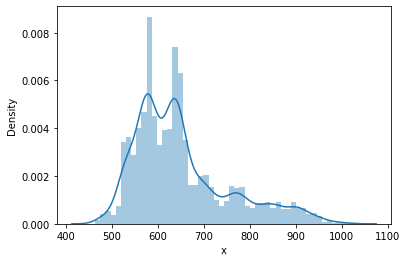

In [19]:
sns.distplot(train_df[train_df.y == 1].x);

In [26]:
train_df[train_df.y == 1].x.max()

1024

In [32]:
train_df[train_df.y == 1].x.median()

628.0

In [27]:
train_df[train_df.y == 1].x.min()

464

/Users/polinashpudeiko/miniconda3/envs/numpy/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


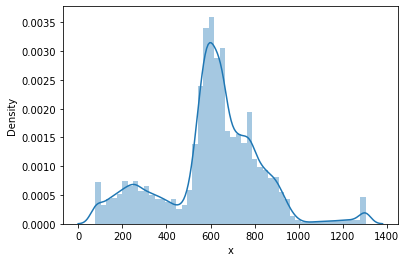

In [44]:
sns.distplot(train_df[train_df.y == 0].x.clip(
        np.quantile(train_df[train_df.y == 0].x, 0.01), 
        np.quantile(train_df[train_df.y == 0].x, 0.99)),);

Clipped data

/Users/polinashpudeiko/miniconda3/envs/numpy/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/polinashpudeiko/miniconda3/envs/numpy/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


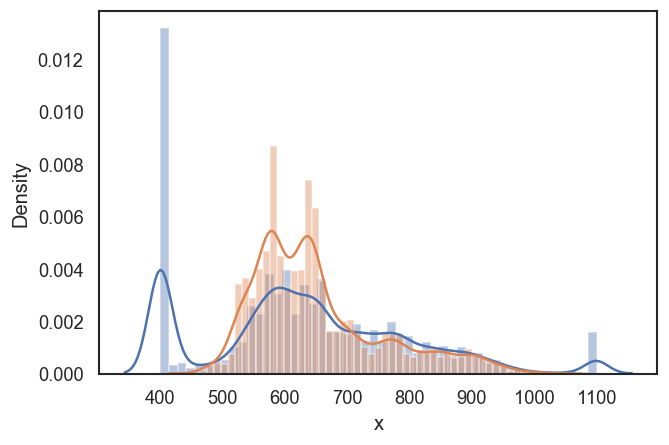

In [463]:
sns.distplot(train_df[train_df.y == 0].x.clip(
        np.quantile(train_df[train_df.y == 0].x, 0.01), 
        np.quantile(train_df[train_df.y == 0].x, 0.99)),);
sns.distplot(train_df[train_df.y == 1].x);

/Users/polinashpudeiko/miniconda3/envs/numpy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


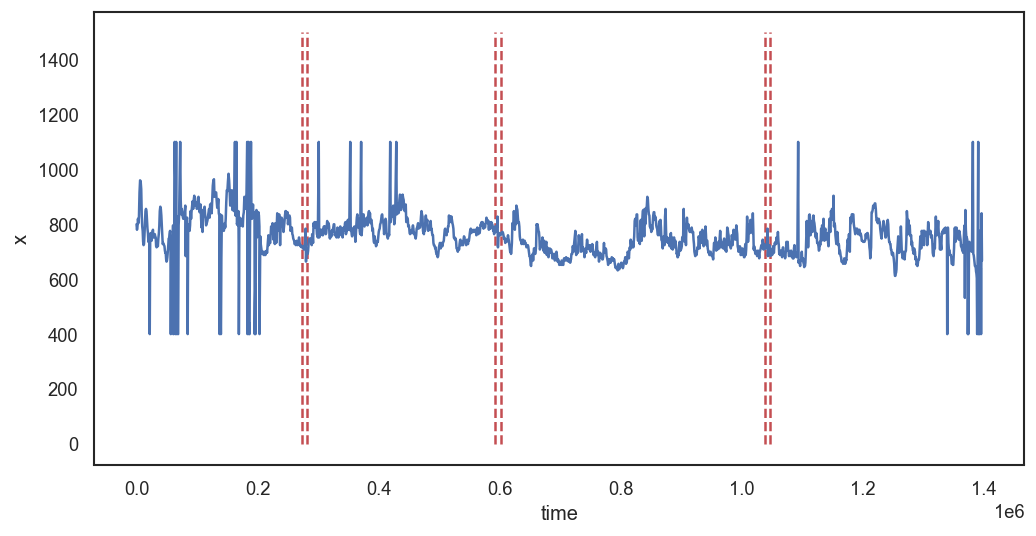

In [464]:
_, ax = plt.subplots(1,1,figsize=(10,5))
sns.lineplot(train_df[train_df.id == 1].time,train_df[train_df.id == 1].x, ax=ax,)
ax.vlines(x=272904, ymin=0, ymax=1500, color='r', linestyles='--')
ax.vlines(x=282200, ymin=0, ymax=1500, color='r', linestyles='--')

ax.vlines(x=591832, ymin=0, ymax=1500, color='r', linestyles='--')
ax.vlines(x=601884, ymin=0, ymax=1500, color='r', linestyles='--')

ax.vlines(x=1039168, ymin=0, ymax=1500, color='r', linestyles='--')
ax.vlines(x=1046348, ymin=0, ymax=1500, color='r', linestyles='--')

/Users/polinashpudeiko/miniconda3/envs/numpy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


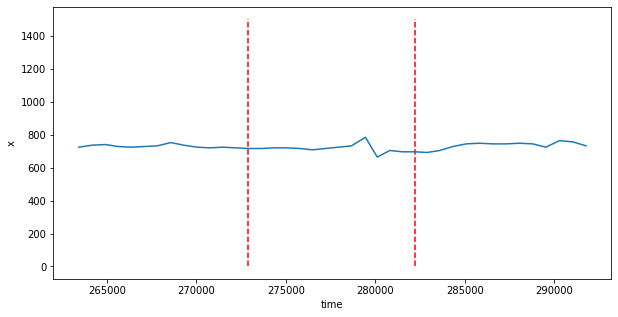

In [8]:
_, ax = plt.subplots(1,1,figsize=(10,5))
sns.lineplot(train_df[train_df.id == 1][340:380].time,train_df[train_df.id == 1][340:380].x, ax=ax,)
ax.vlines(x=272904, ymin=0, ymax=1500, color='r', linestyles='--')
ax.vlines(x=282200, ymin=0, ymax=1500, color='r', linestyles='--')

# ax.vlines(x=591832, ymin=0, ymax=1500, color='r', linestyles='--')
# ax.vlines(x=601884, ymin=0, ymax=1500, color='r', linestyles='--')

# ax.vlines(x=1039168, ymin=0, ymax=1500, color='r', linestyles='--')
# ax.vlines(x=1046348, ymin=0, ymax=1500, color='r', linestyles='--')

/Users/polinashpudeiko/miniconda3/envs/numpy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


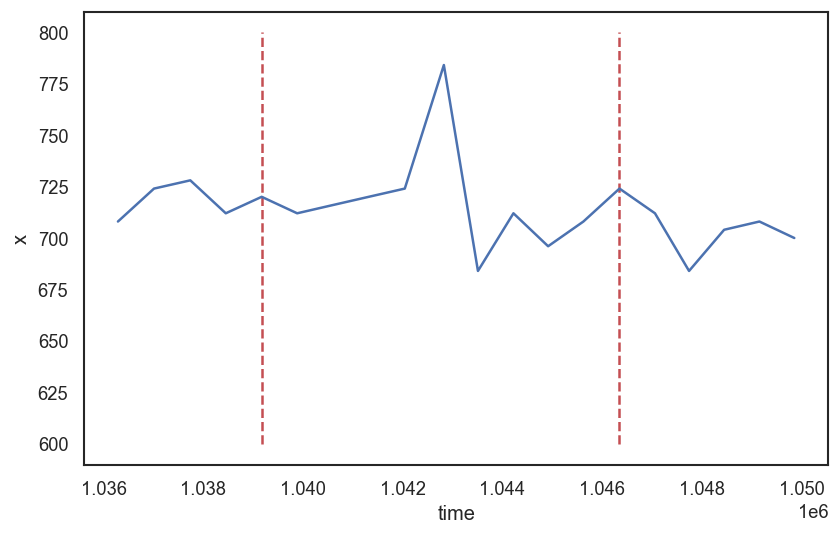

In [467]:
_, ax = plt.subplots(1,1,figsize=(8,5))
sns.lineplot(train_df[train_df.id == 1][1370:1390].time,train_df[train_df.id == 1][1360:1390].x, ax=ax,)
# ax.vlines(x=272904, ymin=0, ymax=1500, color='r', linestyles='--')
# ax.vlines(x=282200, ymin=0, ymax=1500, color='r', linestyles='--')

# ax.vlines(x=591832, ymin=0, ymax=1500, color='r', linestyles='--')
# ax.vlines(x=601884, ymin=0, ymax=1500, color='r', linestyles='--')

ax.vlines(x=1039168, ymin=600, ymax=800, color='r', linestyles='--')
ax.vlines(x=1046348, ymin=600, ymax=800, color='r', linestyles='--')

/Users/polinashpudeiko/miniconda3/envs/numpy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='time', ylabel='x'>

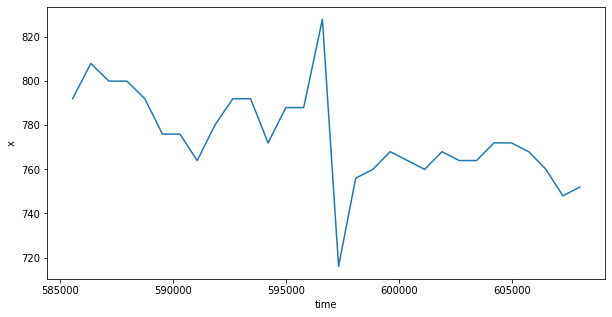

In [13]:
_, ax = plt.subplots(1,1,figsize=(10,5))
sns.lineplot(train_df[train_df.id == 1][750:780].time,train_df[train_df.id == 1][750:780].x, ax=ax,)

/Users/polinashpudeiko/miniconda3/envs/numpy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='time', ylabel='x'>

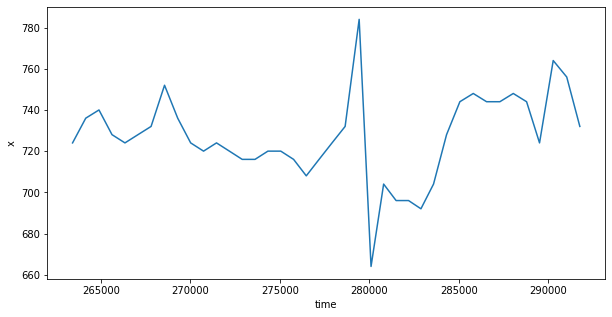

In [16]:
_, ax = plt.subplots(1,1,figsize=(10,5))
sns.lineplot(train_df[train_df.id == 1][340:380].time,train_df[train_df.id == 1][340:380].x, ax=ax,)

Total profile for patient

/Users/polinashpudeiko/miniconda3/envs/numpy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='time', ylabel='x'>

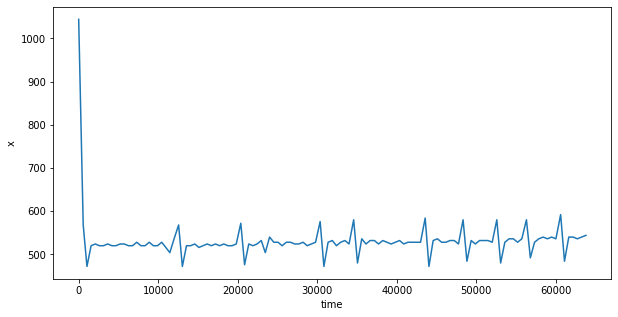

In [69]:
_, ax = plt.subplots(1,1,figsize=(10,5))
sns.lineplot(train_df[train_df.id == 91].time,train_df[train_df.id == 91].x, ax=ax,)

### Length and spike coordinates

In [77]:
res = {}
c = 1
for i in range(1,len(train_df)):
    if train_df.iloc[i-1].y == 0 and train_df.iloc[i].y == 1:
        coord = [i]
    if train_df.iloc[i-1].y == 1 and train_df.iloc[i].y == 1:
        c+=1
    if train_df.iloc[i-1].y == 1 and train_df.iloc[i].y == 0:
        coord.append(i-1)
        if train_df.iloc[i-1].id in res.keys():
            res[train_df.iloc[i-1].id].append(c)
            res[train_df.iloc[i-1].id].append(coord)
        else:
            res[train_df.iloc[i-1].id] = [c]
            res[train_df.iloc[i-1].id].append(coord)
        c = 1

## Metrics calculation

### RMSSD with sliding window

In [314]:
res = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i == 0 or i == 1 or i == 2:
            res.append(np.sqrt((data.iloc[1].x**2 + data.iloc[2].x**2) / 2))
        else:
            res.append(np.sqrt((data.iloc[i-1].x**2 + data.iloc[i].x**2) / 2))

In [315]:
train_df = pd.concat([train_df, pd.Series(res, name='RMSSD_3')],axis=1)

In [316]:
res = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in [0, 1, 2, 3, 4]:
            res.append(np.sqrt((data.iloc[1].x**2 + data.iloc[2].x**2 + data.iloc[3].x**2 + data.iloc[4].x**2 ) / 4))
        else:
            res.append(np.sqrt((data.iloc[i-3].x**2 + data.iloc[i-2].x**2 + data.iloc[i-1].x**2 + data.iloc[i].x**2) / 4))

In [317]:
train_df = pd.concat([train_df, pd.Series(res, name='RMSSD_5')],axis=1)

In [318]:
res = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in [0, 1, 2, 3, 4,5,6]:
            res.append(np.sqrt((data.iloc[1].x**2 + data.iloc[2].x**2 + data.iloc[3].x**2 + data.iloc[4].x**2  + data.iloc[5].x**2 + data.iloc[6].x**2) / 6))
        else:
            res.append(np.sqrt((data.iloc[i-5].x**2 + data.iloc[i-4].x**2 +data.iloc[i-3].x**2 + data.iloc[i-2].x**2 + data.iloc[i-1].x**2 + data.iloc[i].x**2) / 4))

In [319]:
train_df = pd.concat([train_df, pd.Series(res, name='RMSSD_7')],axis=1)

In [130]:
train_df.to_csv('train_with_rmssd.tsv')

### pNN50 with sliding window

In [320]:
res_total = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(10)):
            res = []
            for elm in list(window(np.arange(0,10,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 50:
                    res.append(tmp)
            
            res_total.append(len(res)*10)
        else:   
            res = []
            for elm in list(window(np.arange(i-9,i+1,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 50:
                    res.append(tmp)
                    
            res_total.append(len(res)*10)

In [321]:
train_df = pd.concat([train_df, pd.Series(res_total, name='pNN50_10')],axis=1)

In [322]:
res_total = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(20)):
            res = []
            for elm in list(window(np.arange(0,20,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 50:
                    res.append(tmp)
            
            res_total.append(len(res)*5)
        else:   
            res = []
            for elm in list(window(np.arange(i-19,i+1,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 50:
                    res.append(tmp)
                    
            res_total.append(len(res)*5)

In [323]:
train_df = pd.concat([train_df, pd.Series(res_total, name='pNN50_20')],axis=1)

In [324]:
res_total = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(30)):
            res = []
            for elm in list(window(np.arange(0,30,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 50:
                    res.append(tmp)
            
            res_total.append(100*len(res)/30)
        else:   
            res = []
            for elm in list(window(np.arange(i-29,i+1,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 50:
                    res.append(tmp)
                    
            res_total.append(100*len(res)/30)

In [325]:
train_df = pd.concat([train_df, pd.Series(res_total, name='pNN50_30')],axis=1)

In [185]:
train_df.to_csv('train_with_rmssd_pnn50.tsv')

In [461]:
res = []
for name, data in train_df.groupby('id'): 
    if len(data) >= 40:
        for i in range(len(data)):
            if i in list(range(40)):
                res = []
                for elm in list(window(np.arange(0,30,1))):
                    tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                    if tmp > 50:
                        res.append(tmp)

                res_total.append(100*len(res)/30)
            else:
                res = []
                for elm in list(window(np.arange(i-29,i+1,1))):
                    tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                    if tmp > 50:
                        res.append(tmp)

                res_total.append(100*len(res)/30)
    else:
        for i in range(len(data)):
            res = []
            for elm in list(window(np.arange(0,len(data),1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 50:
                    res.append(tmp)

            res_total.append(100*len(res)/30)

In [ ]:
train_df = pd.concat([train_df, pd.Series(res_total, name='pNN50_40')],axis=1)

### pNN30 with sliding window

In [326]:
res_total = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(10)):
            res = []
            for elm in list(window(np.arange(0,10,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 30:
                    res.append(tmp)
            
            res_total.append(len(res)*10)
        else:   
            res = []
            for elm in list(window(np.arange(i-9,i+1,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 30:
                    res.append(tmp)
                    
            res_total.append(len(res)*10)

In [327]:
train_df = pd.concat([train_df, pd.Series(res_total, name='pNN30_10')],axis=1)

In [328]:
res_total = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(20)):
            res = []
            for elm in list(window(np.arange(0,20,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 30:
                    res.append(tmp)
            
            res_total.append(len(res)*5)
        else:   
            res = []
            for elm in list(window(np.arange(i-19,i+1,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 30:
                    res.append(tmp)
                    
            res_total.append(len(res)*5)

In [329]:
train_df = pd.concat([train_df, pd.Series(res_total, name='pNN30_20')],axis=1)

In [330]:
res_total = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(30)):
            res = []
            for elm in list(window(np.arange(0,30,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 30:
                    res.append(tmp)
            
            res_total.append(100*len(res)/30)
        else:   
            res = []
            for elm in list(window(np.arange(i-29,i+1,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 30:
                    res.append(tmp)
                    
            res_total.append(100*len(res)/30)

In [331]:
train_df = pd.concat([train_df, pd.Series(res_total, name='pNN30_30')],axis=1)

In [193]:
train_df.to_csv('train_with_rmssd_pnn30.tsv')

In [214]:
train_df = pd.read_csv('train_with_rmssd_pnn30.tsv',index_col=0)

### SDNN with sliding window

In [332]:
res = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i == 0 or i == 1 or i == 2:
            res.append(np.std(data.iloc[0:3].x))
        else:
            res.append(np.std(data.iloc[i-2:i+1].x))

In [333]:
train_df = pd.concat([train_df, pd.Series(res, name='SDNN_3')],axis=1)

In [334]:
res = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in [0, 1, 2, 3, 4]:
            res.append(np.std(data.iloc[0:5].x))
        else:
            res.append(np.std(data.iloc[i-4:i+1].x))

In [335]:
train_df = pd.concat([train_df, pd.Series(res, name='SDNN_5')],axis=1)

In [336]:
res = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in [0, 1, 2, 3, 4,5,6]:
            res.append(np.std(data.iloc[0:7].x))
        else:
            res.append(np.std(data.iloc[i-6:i+1].x))

In [337]:
train_df = pd.concat([train_df, pd.Series(res, name='SDNN_7')],axis=1)

In [338]:
res = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(10)):
            res.append(np.std(data.iloc[0:10].x))
        else:
            res.append(np.std(data.iloc[i-9:i+1].x))

In [339]:
train_df = pd.concat([train_df, pd.Series(res, name='SDNN_10')],axis=1)

In [340]:
res = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(20)):
            res.append(np.std(data.iloc[0:20].x))
        else:
            res.append(np.std(data.iloc[i-19:i+1].x))

In [341]:
train_df = pd.concat([train_df, pd.Series(res, name='SDNN_20')],axis=1)

In [227]:
train_df.to_csv('train_with_rmssd_pnn30_sdnn.tsv')

### SI with sliding window

In [342]:
res = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(10)):
            statistic_m = stats.mode(data.iloc[0:10].x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data.iloc[0:10].x.max() - data.iloc[0:10].x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si)
        else:
            data_sub = data.iloc[i-9:i+1]
            statistic_m = stats.mode(data_sub.x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data_sub.x.max() - data_sub.x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si)

<ipython-input-342-25538d4bbb54>:17: RuntimeWarning: divide by zero encountered in double_scalars
  si = Amo / (2 * Mo * MxDMn)
<ipython-input-342-25538d4bbb54>:9: RuntimeWarning: divide by zero encountered in double_scalars
  si = Amo / (2 * Mo * MxDMn)


In [343]:
train_df = pd.concat([train_df, pd.Series(res, name='SI_10')],axis=1)

In [344]:
res = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(5)):
            statistic_m = stats.mode(data.iloc[0:5].x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data.iloc[0:5].x.max() - data.iloc[0:5].x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si)
        else:
            data_sub = data.iloc[i-4:i+1]
            statistic_m = stats.mode(data_sub.x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data_sub.x.max() - data_sub.x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si)

<ipython-input-344-3a1ebb136b53>:17: RuntimeWarning: divide by zero encountered in double_scalars
  si = Amo / (2 * Mo * MxDMn)
<ipython-input-344-3a1ebb136b53>:9: RuntimeWarning: divide by zero encountered in double_scalars
  si = Amo / (2 * Mo * MxDMn)


In [345]:
train_df = pd.concat([train_df, pd.Series(res, name='SI_5')],axis=1)

In [346]:
res = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(20)):
            statistic_m = stats.mode(data.iloc[0:20].x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data.iloc[0:20].x.max() - data.iloc[0:20].x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si)
        else:
            data_sub = data.iloc[i-19:i+1]
            statistic_m = stats.mode(data_sub.x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data_sub.x.max() - data_sub.x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si)

<ipython-input-346-a3235293bf5f>:17: RuntimeWarning: divide by zero encountered in double_scalars
  si = Amo / (2 * Mo * MxDMn)
<ipython-input-346-a3235293bf5f>:9: RuntimeWarning: divide by zero encountered in double_scalars
  si = Amo / (2 * Mo * MxDMn)


In [347]:
train_df = pd.concat([train_df, pd.Series(res, name='SI_20')],axis=1)

In [348]:
train_df.SI_10 = train_df.SI_10 * 1000
train_df.SI_5 = train_df.SI_5 * 1000
train_df.SI_20 = train_df.SI_20 * 1000

In [349]:
res = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(30)):
            statistic_m = stats.mode(data.iloc[0:30].x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data.iloc[0:30].x.max() - data.iloc[0:30].x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si*1000)
        else:
            data_sub = data.iloc[i-29:i+1]
            statistic_m = stats.mode(data_sub.x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data_sub.x.max() - data_sub.x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si*1000)

<ipython-input-349-f36f99feedd7>:17: RuntimeWarning: divide by zero encountered in double_scalars
  si = Amo / (2 * Mo * MxDMn)
<ipython-input-349-f36f99feedd7>:9: RuntimeWarning: divide by zero encountered in double_scalars
  si = Amo / (2 * Mo * MxDMn)


In [350]:
train_df = pd.concat([train_df, pd.Series(res, name='SI_30')],axis=1)

In [351]:
res = []
for name, data in train_df.groupby('id'): 
    if len(data) >= 40:
        for i in range(len(data)):
            if i in list(range(40)):
                statistic_m = stats.mode(data.iloc[0:40].x)
                Mo = statistic_m[0][0]
                Amo = 100*statistic_m[1][0]/10
                MxDMn = data.iloc[0:40].x.max() - data.iloc[0:40].x.min()
                si = Amo / (2 * Mo * MxDMn)
                res.append(si*1000)
            else:
                data_sub = data.iloc[i-39:i+1]
                statistic_m = stats.mode(data_sub.x)
                Mo = statistic_m[0][0]
                Amo = 100*statistic_m[1][0]/10
                MxDMn = data_sub.x.max() - data_sub.x.min()
                si = Amo / (2 * Mo * MxDMn)
                res.append(si*1000)
    else:
        for i in range(len(data)):
            statistic_m = stats.mode(data.iloc[0:len(data)].x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data.iloc[0:len(data)].x.max() - data.iloc[0:len(data)].x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si*1000)

<ipython-input-351-c31502dc400d>:18: RuntimeWarning: divide by zero encountered in double_scalars
  si = Amo / (2 * Mo * MxDMn)


In [352]:
train_df = pd.concat([train_df, pd.Series(res, name='SI_40')],axis=1)

In [256]:
train_df.to_csv('train_with_rmssd_pnn30_sdnn_si.tsv')

### SDSD with sliding window

In [353]:
res = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(5)):
            diff = []
            for elm in list(window(np.arange(0,5,1))):
                diff.append(data.iloc[elm[0]].x - data.iloc[elm[1]].x)

            res.append(np.std(diff))
            
        else:
            diff = []
            for elm in list(window(np.arange(i-4,i+1,1))):
                diff.append(data.iloc[elm[0]].x - data.iloc[elm[1]].x)

            res.append(np.std(diff))

In [354]:
train_df = pd.concat([train_df, pd.Series(res, name='SDSD_5')],axis=1)

In [355]:
res = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(10)):
            diff = []
            for elm in list(window(np.arange(0,10,1))):
                diff.append(data.iloc[elm[0]].x - data.iloc[elm[1]].x)

            res.append(np.std(diff))
            
        else:
            diff = []
            for elm in list(window(np.arange(i-9,i+1,1))):
                diff.append(data.iloc[elm[0]].x - data.iloc[elm[1]].x)

            res.append(np.std(diff))

In [356]:
train_df = pd.concat([train_df, pd.Series(res, name='SDSD_10')],axis=1)

In [357]:
res = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(20)):
            diff = []
            for elm in list(window(np.arange(0,20,1))):
                diff.append(data.iloc[elm[0]].x - data.iloc[elm[1]].x)

            res.append(np.std(diff))
            
        else:
            diff = []
            for elm in list(window(np.arange(i-19,i+1,1))):
                diff.append(data.iloc[elm[0]].x - data.iloc[elm[1]].x)

            res.append(np.std(diff))

In [358]:
train_df = pd.concat([train_df, pd.Series(res, name='SDSD_20')],axis=1)

In [359]:
train_df['SD1_5'] = np.sqrt(0.5 * train_df.SDSD_5.apply(lambda x: x ** 2))
train_df['SD1_10'] = np.sqrt(0.5 * train_df.SDSD_10.apply(lambda x: x ** 2))
train_df['SD1_20'] = np.sqrt(0.5 * train_df.SDSD_20.apply(lambda x: x ** 2))

In [360]:
train_df.to_csv('train_with_rmssd_pnn30_sdnn_si_sd_clipped.tsv')

### Simple spike search

In [453]:
res = []
for name, data in train_df.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(4)):
            if data.iloc[2].x < data.iloc[0].x < data.iloc[1].x and data.iloc[2].x < data.iloc[3].x < data.iloc[1].x:
                res.append(1)
            else:
                res.append(0)
        else:
            
            if data.iloc[i-1].x < data.iloc[i-3].x < data.iloc[i-2].x and data.iloc[i-1].x < data.iloc[i].x < data.iloc[i-2].x:
                res.append(1)
            else:
                res.append(0)

In [441]:
train_df = pd.concat([train_df, pd.Series(res, name='by_hands')],axis=1)

In [455]:
train_df[train_df.y ==1]['by_hands'].value_counts()

0    7770
1    1191
Name: by_hands, dtype: int64

In [456]:
pd.DataFrame(res).value_counts()

0    57121
1     3366
dtype: int64

## Correlation between metrics

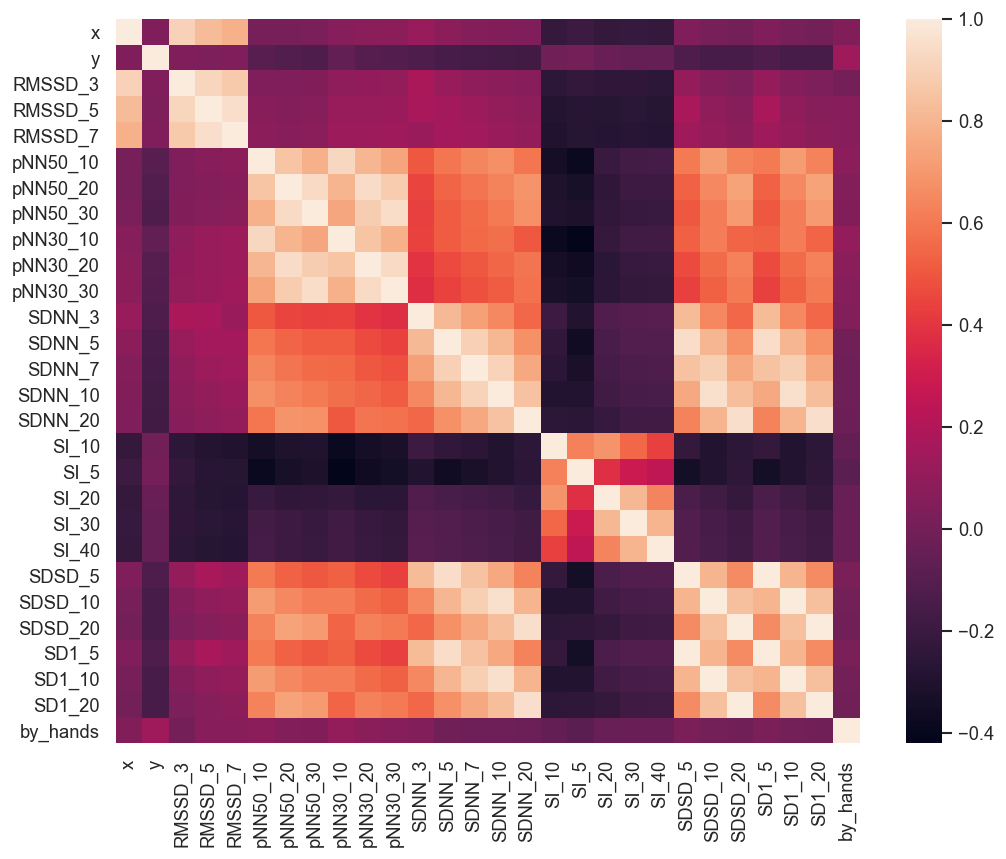

In [460]:
_, ax = plt.subplots(1,1,figsize=(10,8))
sns.heatmap(train_df[['x', 'y', 'RMSSD_3', 'RMSSD_5', 'RMSSD_7', 'pNN50_10',
       'pNN50_20', 'pNN50_30', 'pNN30_10', 'pNN30_20', 'pNN30_30', 'SDNN_3',
       'SDNN_5', 'SDNN_7', 'SDNN_10', 'SDNN_20', 'SI_10', 'SI_5', 'SI_20', 'SI_30', 'SI_40',
       'SDSD_5', 'SDSD_10', 'SDSD_20', 'SD1_5', 'SD1_10', 'SD1_20','by_hands']].corr(),ax=ax);
# plt.savefig('heatmap_feature.png',dpi=300)

In [458]:
train_df[['x', 'y', 'RMSSD_3', 'RMSSD_5', 'RMSSD_7', 'pNN50_10',
       'pNN50_20', 'pNN50_30', 'pNN30_10', 'pNN30_20', 'pNN30_30', 'SDNN_3',
       'SDNN_5', 'SDNN_7', 'SDNN_10', 'SDNN_20', 'SI_10', 'SI_5', 'SI_20', 'SI_30', 'SI_40',
       'SDSD_5', 'SDSD_10', 'SDSD_20', 'SD1_5', 'SD1_10', 'SD1_20','by_hands']].corr().y

x           0.037274
y           1.000000
RMSSD_3     0.034434
RMSSD_5     0.033915
RMSSD_7     0.039380
pNN50_10   -0.090683
pNN50_20   -0.119345
pNN50_30   -0.128564
pNN30_10   -0.062727
pNN30_20   -0.099354
pNN30_30   -0.112265
SDNN_3     -0.131383
SDNN_5     -0.151763
SDNN_7     -0.163331
SDNN_10    -0.170924
SDNN_20    -0.174658
SI_10      -0.015761
SI_5        0.003801
SI_20      -0.037631
SI_30      -0.044096
SI_40      -0.047920
SDSD_5     -0.131538
SDSD_10    -0.151248
SDSD_20    -0.153569
SD1_5      -0.131538
SD1_10     -0.151248
SD1_20     -0.153569
by_hands    0.140550
Name: y, dtype: float64

In [459]:
train_df.to_csv('train_with_rmssd_pnn30_sdnn_si_sd_craft.tsv')

## Poincare plots

In [371]:
train_df_sub = train_df[train_df.x < 1100]
train_df_sub = train_df[train_df.x > 400]

In [424]:
res = []
for x in range(len(train_df_sub[train_df_sub.id == 1])-1):
    res.append([train_df_sub[train_df_sub.id == 1].iloc[x].x,
                train_df_sub[train_df_sub.id == 1].iloc[x+1].x,
                train_df_sub[train_df_sub.id == 1].iloc[x+1].y])

In [425]:
res_poincare = pd.DataFrame(res)

In [426]:
res_poincare.columns = ['RRi', 'RRi+1', 'Spike status']

/Users/polinashpudeiko/miniconda3/envs/numpy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


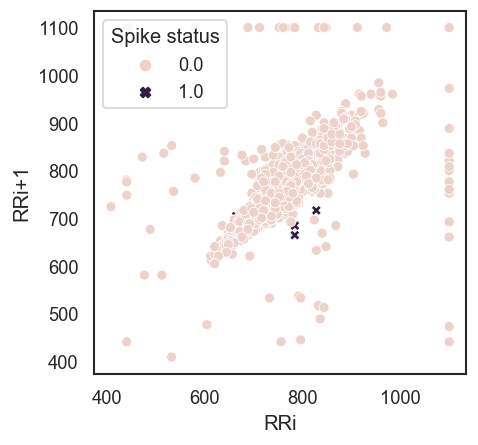

In [427]:
_, ax = plt.subplots(1,1,figsize=(4,4))
sns.scatterplot(res_poincare['RRi'],res_poincare['RRi+1'],ax=ax,hue=res_poincare['Spike status'],
                hue_norm=(0,1),style=res_poincare['Spike status'])
plt.savefig('poinc_1.png',dpi=300)

In [415]:
res = []
for x in range(len(train_df_sub[train_df_sub.id == 100])-1):
    res.append([train_df_sub[train_df_sub.id == 100].iloc[x].x,
                train_df_sub[train_df_sub.id == 100].iloc[x+1].x,
                train_df_sub[train_df_sub.id == 100].iloc[x+1].y])

In [416]:
res_poincare = pd.DataFrame(res)

In [417]:
res_poincare.columns = ['RRi', 'RRi+1', 'Spike status']

/Users/polinashpudeiko/miniconda3/envs/numpy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


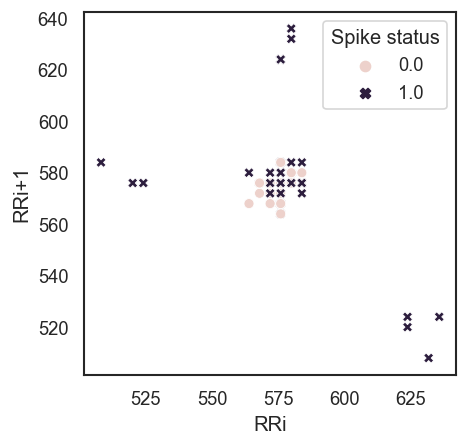

In [423]:
_, ax = plt.subplots(1,1,figsize=(4,4))
sns.scatterplot(res_poincare['RRi'],res_poincare['RRi+1'],ax=ax,hue=res_poincare['Spike status'],
                hue_norm=(0,1),style=res_poincare['Spike status'])
plt.savefig('poinc_100.png',dpi=300)

In [428]:
res = []
for x in range(len(train_df_sub[train_df_sub.id == 132])-1):
    res.append([train_df_sub[train_df_sub.id == 132].iloc[x].x,
                train_df_sub[train_df_sub.id == 132].iloc[x+1].x,
                train_df_sub[train_df_sub.id == 132].iloc[x+1].y])

In [429]:
res_poincare = pd.DataFrame(res)

In [430]:
res_poincare.columns = ['RRi', 'RRi+1', 'Spike status']

/Users/polinashpudeiko/miniconda3/envs/numpy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


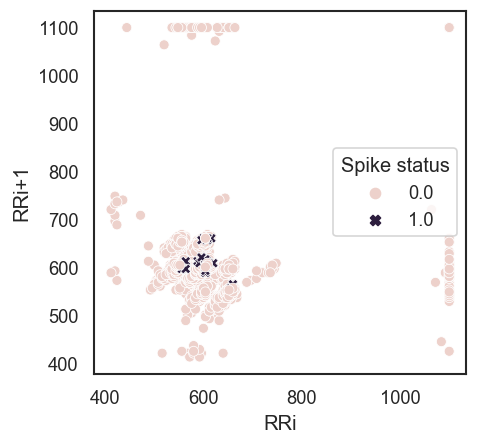

In [435]:
_, ax = plt.subplots(1,1,figsize=(4,4))
sns.scatterplot(res_poincare['RRi'],res_poincare['RRi+1'],ax=ax,hue=res_poincare['Spike status'],
                hue_norm=(0,1),style=res_poincare['Spike status'])
# plt.savefig('poinc_132.png',dpi=300)

## CatBoost

In [9]:
data_cat = pd.read_csv('train_with_rmssd_pnn30_sdnn_si_sd_craft.tsv',index_col=0)

In [10]:
data_cat = data_cat.replace([np.inf, -np.inf], np.nan)

In [13]:
X_train_cat_2 = data_cat[data_cat.id < 200][['RMSSD_3', 'RMSSD_5', 'RMSSD_7', 'pNN50_10',
       'pNN50_20', 'pNN50_30', 'pNN30_10', 'pNN30_20', 'pNN30_30', 'SDNN_3',
       'SDNN_5', 'SDNN_7', 'SDNN_10', 'SDNN_20', 'SI_10', 'SI_5', 'SI_20',
       'SI_30', 'SI_40', 'SDSD_5', 'SDSD_10', 'SDSD_20', 'SD1_5', 'SD1_10',
       'SD1_20', 'by_hands']]
X_valid_cat_2 = data_cat[data_cat.id >= 200][['RMSSD_3', 'RMSSD_5', 'RMSSD_7', 'pNN50_10',
       'pNN50_20', 'pNN50_30', 'pNN30_10', 'pNN30_20', 'pNN30_30', 'SDNN_3',
       'SDNN_5', 'SDNN_7', 'SDNN_10', 'SDNN_20', 'SI_10', 'SI_5', 'SI_20',
       'SI_30', 'SI_40', 'SDSD_5', 'SDSD_10', 'SDSD_20', 'SD1_5', 'SD1_10',
       'SD1_20', 'by_hands']]
y_train_cat_2 = data_cat[data_cat.id < 200]['y'].values
y_valid_cat_2 = data_cat[data_cat.id >= 200]['y'].values

In [14]:
cat_cols = ['by_hands']

In [15]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, 
                                             cat_features=cat_cols,
                                             silent=True)

boosting_model.fit(X_train_cat_2, y_train_cat_2)

In [16]:
y_train_predicted = boosting_model.predict(X_train_cat_2)
y_test_predicted = boosting_model.predict(X_valid_cat_2)

In [18]:

print('Best score -', roc_auc_score(y_train_cat_2, y_train_predicted,multi_class='ovo'))

Best score - 0.8010868684223652


In [19]:
print('Best score -', roc_auc_score(y_valid_cat_2, y_test_predicted,multi_class='ovo'))

Best score - 0.6292345342431142


In [21]:
boosting_model = catboost.CatBoostClassifier(#iterations=300,
                                             silent=True,
                                             cat_features=cat_cols,
                                        loss_function='Logloss',
                                        eval_metric= 'TotalF1',)
grid_search_result = boosting_model.randomized_search({'learning_rate': np.linspace(0, 0.9, 20),
                            'l2_leaf_reg': np.linspace(0, 10, 100),
                            'depth': [2, 3, 4, 5, 6, 7,8],
                            'iterations': [200,500,700,900],
                            'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']}, 
                           X_train_cat_2,
                    y_train_cat_2, plot=True, refit=True,   );

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8904495336
bestIteration = 662

0:	loss: 0.8904495	best: 0.8904495 (0)	total: 4.96s	remaining: 44.6s

bestTest = 0.8851863439
bestIteration = 469

1:	loss: 0.8851863	best: 0.8904495 (0)	total: 8.69s	remaining: 34.8s

bestTest = 0.8998366298
bestIteration = 409

2:	loss: 0.8998366	best: 0.8998366 (2)	total: 13.4s	remaining: 31.3s

bestTest = 0.9295592988
bestIteration = 619

3:	loss: 0.9295593	best: 0.9295593 (3)	total: 28.5s	remaining: 42.7s

bestTest = 0.9302777538
bestIteration = 696

4:	loss: 0.9302778	best: 0.9302778 (4)	total: 46.6s	remaining: 46.6s

bestTest = 0.9349795089
bestIteration = 888

5:	loss: 0.9349795	best: 0.9349795 (5)	total: 1m 39s	remaining: 1m 6s

bestTest = 0.8927681711
bestIteration = 899

6:	loss: 0.8927682	best: 0.9349795 (5)	total: 2m 2s	remaining: 52.4s

bestTest = 0.9154145675
bestIteration = 197

7:	loss: 0.9154146	best: 0.9349795 (5)	total: 2m 9s	remaining: 32.5s

bestTest = 0.9312957241
bestIteration = 814

8:	loss: 0.9312957	best: 0.934979

In [22]:
grid_search_result['params']

{'depth': 8,
 'iterations': 900,
 'learning_rate': 0.5684210526315789,
 'l2_leaf_reg': 9.191919191919192,
 'grow_policy': 'Depthwise'}

In [23]:
boosting_model = catboost.CatBoostClassifier(iterations=900, 
                                             cat_features=cat_cols,
                                             learning_rate=0.5684210526315789,
                                             l2_leaf_reg=9.191919191919192,
                                             grow_policy='Depthwise',
                                             depth=8,
                                             silent=True)

boosting_model.fit(X_train_cat_2, y_train_cat_2)

In [24]:
print('Best score -', roc_auc_score(y_train_cat_2, y_train_predicted,multi_class='ovo'))

Best score - 0.8010868684223652


In [25]:
y_train_predicted = boosting_model.predict(X_train_cat_2)
y_test_predicted = boosting_model.predict(X_valid_cat_2)

In [26]:

m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_valid_cat_2, y_test_predicted)
m.result().numpy()

0.85885054

In [27]:

f1_score(y_valid_cat_2, y_test_predicted, average='binary')

0.37945368171021376

In [28]:

explainer = shap.TreeExplainer(boosting_model)
shap_values = explainer.shap_values(X_valid_cat_2)

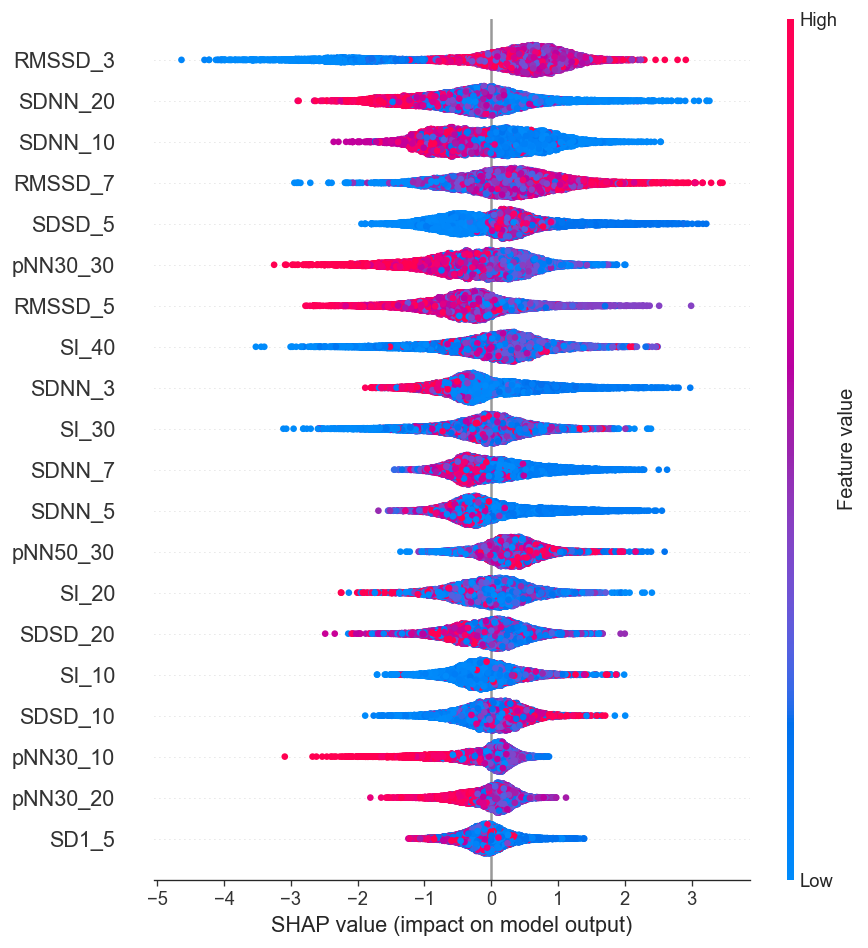

In [29]:
shap.summary_plot(shap_values, X_valid_cat_2, #plot_type="bar"
)

In [30]:
vals= np.abs(shap_values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_valid_cat_2.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head()

,col_name,feature_importance_vals
0,RMSSD_3,0.844855
13,SDNN_20,0.613997
12,SDNN_10,0.608225
2,RMSSD_7,0.599117
19,SDSD_5,0.561965


In [55]:
best_features = feature_importance[0:20].col_name.values

In [186]:
best_features

array(['RMSSD_3', 'SDNN_20', 'SDNN_10', 'RMSSD_7', 'SDSD_5', 'pNN30_30',
       'RMSSD_5', 'SI_40', 'SDNN_3', 'SI_30', 'SDNN_7', 'SDNN_5',
       'pNN50_30', 'SI_20', 'SDSD_20', 'SI_10', 'SDSD_10', 'pNN30_10',
       'pNN30_20', 'SD1_5'], dtype=object)

In [56]:
X_train_cat_2 = data_cat[data_cat.id < 200][best_features]
X_valid_cat_2 = data_cat[data_cat.id >= 200][best_features]
y_train_cat_2 = data_cat[data_cat.id < 200]['y'].values
y_valid_cat_2 = data_cat[data_cat.id >= 200]['y'].values

In [57]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, 
#                                              cat_features=cat_cols,
                                             silent=True)

boosting_model.fit(X_train_cat_2, y_train_cat_2)

In [58]:
y_train_predicted = boosting_model.predict(X_train_cat_2)
y_test_predicted = boosting_model.predict(X_valid_cat_2)

In [59]:

print('Best score -', roc_auc_score(y_train_cat_2, y_train_predicted,multi_class='ovo'))

Best score - 0.7964739513192678


In [60]:
print('Best score -', roc_auc_score(y_valid_cat_2, y_test_predicted,multi_class='ovo'))

Best score - 0.6192386152446154


In [61]:
boosting_model = catboost.CatBoostClassifier(#iterations=300,
                                             silent=True,
#                                              cat_features=cat_cols,
                                        loss_function='Logloss',
                                        eval_metric= 'TotalF1',)
grid_search_result = boosting_model.randomized_search({'learning_rate': np.linspace(0, 0.9, 20),
                            'l2_leaf_reg': np.linspace(0, 10, 100),
                            'depth': [5, 6, 7,8],
                            'iterations': [200,500,700,900],
                            'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']}, 
                           X_train_cat_2,
                    y_train_cat_2, plot=True, refit=True,   );

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.9228397946
bestIteration = 688

0:	loss: 0.9228398	best: 0.9228398 (0)	total: 6.51s	remaining: 58.6s

bestTest = 0.9254482305
bestIteration = 189

1:	loss: 0.9254482	best: 0.9254482 (1)	total: 11s	remaining: 44s

bestTest = 0.9361044047
bestIteration = 550

2:	loss: 0.9361044	best: 0.9361044 (2)	total: 37.8s	remaining: 1m 28s

bestTest = 0.9352749418
bestIteration = 480

3:	loss: 0.9352749	best: 0.9361044 (2)	total: 59.4s	remaining: 1m 29s

bestTest = 0.9361000565
bestIteration = 482

4:	loss: 0.9361001	best: 0.9361044 (2)	total: 1m 22s	remaining: 1m 22s

bestTest = 0.9403484431
bestIteration = 666

5:	loss: 0.9403484	best: 0.9403484 (5)	total: 1m 56s	remaining: 1m 17s

bestTest = 0.9304631561
bestIteration = 637

6:	loss: 0.9304632	best: 0.9403484 (5)	total: 2m 12s	remaining: 56.6s

bestTest = 0.9339968294
bestIteration = 834

7:	loss: 0.9339968	best: 0.9403484 (5)	total: 2m 31s	remaining: 37.9s

bestTest = 0.9225714711
bestIteration = 894

8:	loss: 0.9225715	best: 0.940

In [62]:
grid_search_result['params']

{'depth': 8,
 'iterations': 700,
 'learning_rate': 0.28421052631578947,
 'l2_leaf_reg': 5.353535353535354,
 'grow_policy': 'Depthwise'}

In [63]:
boosting_model = catboost.CatBoostClassifier(iterations=700, 
#                                              cat_features=cat_cols,
                                             learning_rate=0.28421052631578947,
                                             l2_leaf_reg=5.353535353535354,
                                             grow_policy='Depthwise',
                                             depth=8,
                                             silent=True)

boosting_model.fit(X_train_cat_2, y_train_cat_2)

In [64]:
print('Best score -', roc_auc_score(y_train_cat_2, y_train_predicted,multi_class='ovo'))

Best score - 0.7964739513192678


In [65]:
y_train_predicted = boosting_model.predict(X_train_cat_2)
y_test_predicted = boosting_model.predict(X_valid_cat_2)

In [182]:

m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_valid_cat_2, y_test_predicted)
m.result().numpy()

0.85864794

In [183]:

f1_score(y_valid_cat_2, y_test_predicted, average='binary')

0.3674826231489876

## Test Preprocessing

In [69]:
test = pd.read_csv('test.csv')

In [70]:
test.x = test.x.clip(400, 1100)

In [71]:
res = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i == 0 or i == 1 or i == 2:
            res.append(np.sqrt((data.iloc[1].x**2 + data.iloc[2].x**2) / 2))
        else:
            res.append(np.sqrt((data.iloc[i-1].x**2 + data.iloc[i].x**2) / 2))

In [72]:
test = pd.concat([test, pd.Series(res, name='RMSSD_3')],axis=1)

In [73]:
res = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in [0, 1, 2, 3, 4]:
            res.append(np.sqrt((data.iloc[1].x**2 + data.iloc[2].x**2 + data.iloc[3].x**2 + data.iloc[4].x**2 ) / 4))
        else:
            res.append(np.sqrt((data.iloc[i-3].x**2 + data.iloc[i-2].x**2 + data.iloc[i-1].x**2 + data.iloc[i].x**2) / 4))

In [74]:
test = pd.concat([test, pd.Series(res, name='RMSSD_5')],axis=1)

In [75]:
res = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in [0, 1, 2, 3, 4,5,6]:
            res.append(np.sqrt((data.iloc[1].x**2 + data.iloc[2].x**2 + data.iloc[3].x**2 + data.iloc[4].x**2  + data.iloc[5].x**2 + data.iloc[6].x**2) / 6))
        else:
            res.append(np.sqrt((data.iloc[i-5].x**2 + data.iloc[i-4].x**2 +data.iloc[i-3].x**2 + data.iloc[i-2].x**2 + data.iloc[i-1].x**2 + data.iloc[i].x**2) / 4))

In [76]:
test = pd.concat([test, pd.Series(res, name='RMSSD_7')],axis=1)

In [79]:
res_total = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(10)):
            res = []
            for elm in list(window(np.arange(0,10,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 50:
                    res.append(tmp)
            
            res_total.append(len(res)*10)
        else:   
            res = []
            for elm in list(window(np.arange(i-9,i+1,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 50:
                    res.append(tmp)
                    
            res_total.append(len(res)*10)

In [80]:
test = pd.concat([test, pd.Series(res_total, name='pNN50_10')],axis=1)

In [81]:
res_total = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(20)):
            res = []
            for elm in list(window(np.arange(0,20,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 50:
                    res.append(tmp)
            
            res_total.append(len(res)*5)
        else:   
            res = []
            for elm in list(window(np.arange(i-19,i+1,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 50:
                    res.append(tmp)
                    
            res_total.append(len(res)*5)

In [82]:
test = pd.concat([test, pd.Series(res_total, name='pNN50_20')],axis=1)

In [83]:
res_total = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(30)):
            res = []
            for elm in list(window(np.arange(0,30,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 50:
                    res.append(tmp)
            
            res_total.append(100*len(res)/30)
        else:   
            res = []
            for elm in list(window(np.arange(i-29,i+1,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 50:
                    res.append(tmp)
                    
            res_total.append(100*len(res)/30)

In [84]:
test = pd.concat([test, pd.Series(res_total, name='pNN50_30')],axis=1)

In [85]:
res_total = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(10)):
            res = []
            for elm in list(window(np.arange(0,10,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 30:
                    res.append(tmp)
            
            res_total.append(len(res)*10)
        else:   
            res = []
            for elm in list(window(np.arange(i-9,i+1,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 30:
                    res.append(tmp)
                    
            res_total.append(len(res)*10)

In [86]:
test = pd.concat([test, pd.Series(res_total, name='pNN30_10')],axis=1)

In [87]:
res_total = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(20)):
            res = []
            for elm in list(window(np.arange(0,20,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 30:
                    res.append(tmp)
            
            res_total.append(len(res)*5)
        else:   
            res = []
            for elm in list(window(np.arange(i-19,i+1,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 30:
                    res.append(tmp)
                    
            res_total.append(len(res)*5)

In [88]:
test = pd.concat([test, pd.Series(res_total, name='pNN30_20')],axis=1)

In [89]:
res_total = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(30)):
            res = []
            for elm in list(window(np.arange(0,30,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 30:
                    res.append(tmp)
            
            res_total.append(100*len(res)/30)
        else:   
            res = []
            for elm in list(window(np.arange(i-29,i+1,1))):
                tmp = abs(data.iloc[elm[0]].x - data.iloc[elm[1]].x)
                if tmp > 30:
                    res.append(tmp)
                    
            res_total.append(100*len(res)/30)

In [90]:
test = pd.concat([test, pd.Series(res_total, name='pNN30_30')],axis=1)

In [91]:
res = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i == 0 or i == 1 or i == 2:
            res.append(np.std(data.iloc[0:3].x))
        else:
            res.append(np.std(data.iloc[i-2:i+1].x))

In [92]:
test = pd.concat([test, pd.Series(res, name='SDNN_3')],axis=1)

In [93]:
res = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in [0, 1, 2, 3, 4]:
            res.append(np.std(data.iloc[0:5].x))
        else:
            res.append(np.std(data.iloc[i-4:i+1].x))

In [94]:
test = pd.concat([test, pd.Series(res, name='SDNN_5')],axis=1)

In [95]:
res = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in [0, 1, 2, 3, 4,5,6]:
            res.append(np.std(data.iloc[0:7].x))
        else:
            res.append(np.std(data.iloc[i-6:i+1].x))

In [96]:
test = pd.concat([test, pd.Series(res, name='SDNN_7')],axis=1)

In [97]:
res = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(10)):
            res.append(np.std(data.iloc[0:10].x))
        else:
            res.append(np.std(data.iloc[i-9:i+1].x))

In [98]:
test = pd.concat([test, pd.Series(res, name='SDNN_10')],axis=1)

In [99]:
res = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(20)):
            res.append(np.std(data.iloc[0:20].x))
        else:
            res.append(np.std(data.iloc[i-19:i+1].x))

In [100]:
test = pd.concat([test, pd.Series(res, name='SDNN_20')],axis=1)

In [103]:
res = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(10)):
            statistic_m = stats.mode(data.iloc[0:10].x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data.iloc[0:10].x.max() - data.iloc[0:10].x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si)
        else:
            data_sub = data.iloc[i-9:i+1]
            statistic_m = stats.mode(data_sub.x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data_sub.x.max() - data_sub.x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si)

divide by zero encountered in double_scalars


In [104]:
test = pd.concat([test, pd.Series(res, name='SI_10')],axis=1)

In [105]:
res = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(5)):
            statistic_m = stats.mode(data.iloc[0:5].x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data.iloc[0:5].x.max() - data.iloc[0:5].x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si)
        else:
            data_sub = data.iloc[i-4:i+1]
            statistic_m = stats.mode(data_sub.x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data_sub.x.max() - data_sub.x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si)

divide by zero encountered in double_scalars


In [106]:
test = pd.concat([test, pd.Series(res, name='SI_5')],axis=1)

In [107]:
res = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(20)):
            statistic_m = stats.mode(data.iloc[0:20].x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data.iloc[0:20].x.max() - data.iloc[0:20].x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si)
        else:
            data_sub = data.iloc[i-19:i+1]
            statistic_m = stats.mode(data_sub.x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data_sub.x.max() - data_sub.x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si)

divide by zero encountered in double_scalars


In [108]:
test = pd.concat([test, pd.Series(res, name='SI_20')],axis=1)

In [109]:
test.SI_10 = test.SI_10 * 1000
test.SI_5 = test.SI_5 * 1000
test.SI_20 = test.SI_20 * 1000

In [110]:
res = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(30)):
            statistic_m = stats.mode(data.iloc[0:30].x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data.iloc[0:30].x.max() - data.iloc[0:30].x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si*1000)
        else:
            data_sub = data.iloc[i-29:i+1]
            statistic_m = stats.mode(data_sub.x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data_sub.x.max() - data_sub.x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si*1000)

divide by zero encountered in double_scalars


In [111]:
test = pd.concat([test, pd.Series(res, name='SI_30')],axis=1)

In [112]:
res = []
for name, data in test.groupby('id'): 
    if len(data) >= 40:
        for i in range(len(data)):
            if i in list(range(40)):
                statistic_m = stats.mode(data.iloc[0:40].x)
                Mo = statistic_m[0][0]
                Amo = 100*statistic_m[1][0]/10
                MxDMn = data.iloc[0:40].x.max() - data.iloc[0:40].x.min()
                si = Amo / (2 * Mo * MxDMn)
                res.append(si*1000)
            else:
                data_sub = data.iloc[i-39:i+1]
                statistic_m = stats.mode(data_sub.x)
                Mo = statistic_m[0][0]
                Amo = 100*statistic_m[1][0]/10
                MxDMn = data_sub.x.max() - data_sub.x.min()
                si = Amo / (2 * Mo * MxDMn)
                res.append(si*1000)
    else:
        for i in range(len(data)):
            statistic_m = stats.mode(data.iloc[0:len(data)].x)
            Mo = statistic_m[0][0]
            Amo = 100*statistic_m[1][0]/10
            MxDMn = data.iloc[0:len(data)].x.max() - data.iloc[0:len(data)].x.min()
            si = Amo / (2 * Mo * MxDMn)
            res.append(si*1000)

divide by zero encountered in double_scalars


In [113]:
test = pd.concat([test, pd.Series(res, name='SI_40')],axis=1)

In [114]:
res = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(5)):
            diff = []
            for elm in list(window(np.arange(0,5,1))):
                diff.append(data.iloc[elm[0]].x - data.iloc[elm[1]].x)

            res.append(np.std(diff))
            
        else:
            diff = []
            for elm in list(window(np.arange(i-4,i+1,1))):
                diff.append(data.iloc[elm[0]].x - data.iloc[elm[1]].x)

            res.append(np.std(diff))

In [115]:
test = pd.concat([test, pd.Series(res, name='SDSD_5')],axis=1)

In [116]:
res = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(10)):
            diff = []
            for elm in list(window(np.arange(0,10,1))):
                diff.append(data.iloc[elm[0]].x - data.iloc[elm[1]].x)

            res.append(np.std(diff))
            
        else:
            diff = []
            for elm in list(window(np.arange(i-9,i+1,1))):
                diff.append(data.iloc[elm[0]].x - data.iloc[elm[1]].x)

            res.append(np.std(diff))

In [117]:
test = pd.concat([test, pd.Series(res, name='SDSD_10')],axis=1)

In [118]:
res = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(20)):
            diff = []
            for elm in list(window(np.arange(0,20,1))):
                diff.append(data.iloc[elm[0]].x - data.iloc[elm[1]].x)

            res.append(np.std(diff))
            
        else:
            diff = []
            for elm in list(window(np.arange(i-19,i+1,1))):
                diff.append(data.iloc[elm[0]].x - data.iloc[elm[1]].x)

            res.append(np.std(diff))

In [119]:
test = pd.concat([test, pd.Series(res, name='SDSD_20')],axis=1)

In [120]:
test['SD1_5'] = np.sqrt(0.5 * test.SDSD_5.apply(lambda x: x ** 2))
test['SD1_10'] = np.sqrt(0.5 * test.SDSD_10.apply(lambda x: x ** 2))
test['SD1_20'] = np.sqrt(0.5 * test.SDSD_20.apply(lambda x: x ** 2))

In [121]:
res = []
for name, data in test.groupby('id'):   
    for i in range(len(data)):
        if i in list(range(4)):
            if data.iloc[2].x < data.iloc[0].x < data.iloc[1].x and data.iloc[2].x < data.iloc[3].x < data.iloc[1].x:
                res.append(1)
            else:
                res.append(0)
        else:
            
            if data.iloc[i-1].x < data.iloc[i-3].x < data.iloc[i-2].x and data.iloc[i-1].x < data.iloc[i].x < data.iloc[i-2].x:
                res.append(1)
            else:
                res.append(0)

In [122]:
test = pd.concat([test, pd.Series(res, name='by_hands')],axis=1)

In [123]:
test.to_csv('test_with_rmssd_pnn30_sdnn_si_sd.tsv')

In [125]:
test_to_fit = test[best_features]

In [127]:
test_pred = boosting_model.predict(test_to_fit)

In [129]:
result_test = pd.concat([test[['id', 'time']],pd.DataFrame(test_pred)],axis=1)

result_test.columns = ['id', 'time', 'y']

# result_test.to_csv('prediction.csv', index=False)

In [130]:
result_test

,id,time,y
0,81,0,0
1,81,568,0
2,81,1140,0
3,81,1716,0
4,81,2284,0
...,...,...,...
15029,176,44332,1
15030,176,44968,0
15031,176,45596,0
15032,176,46904,0


In [131]:
result_test.to_csv('prediction_1.csv', index=False)

## DecisionTree

In [160]:
dec_tree = DecisionTreeClassifier(random_state = 42,min_samples_leaf=2)

In [136]:
data_cat = data_cat.replace([np.inf, -np.inf], np.nan)

data_cat = data_cat.fillna(0)

In [137]:
X_train_cat_2 = data_cat[data_cat.id < 200][['RMSSD_3', 'RMSSD_5', 'RMSSD_7', 'pNN50_10',
       'pNN50_20', 'pNN50_30', 'pNN30_10', 'pNN30_20', 'pNN30_30', 'SDNN_3',
       'SDNN_5', 'SDNN_7', 'SDNN_10', 'SDNN_20', 'SI_10', 'SI_5', 'SI_20',
       'SI_30', 'SI_40', 'SDSD_5', 'SDSD_10', 'SDSD_20', 'SD1_5', 'SD1_10',
       'SD1_20', 'by_hands']]
X_valid_cat_2 = data_cat[data_cat.id >= 200][['RMSSD_3', 'RMSSD_5', 'RMSSD_7', 'pNN50_10',
       'pNN50_20', 'pNN50_30', 'pNN30_10', 'pNN30_20', 'pNN30_30', 'SDNN_3',
       'SDNN_5', 'SDNN_7', 'SDNN_10', 'SDNN_20', 'SI_10', 'SI_5', 'SI_20',
       'SI_30', 'SI_40', 'SDSD_5', 'SDSD_10', 'SDSD_20', 'SD1_5', 'SD1_10',
       'SD1_20', 'by_hands']]
y_train_cat_2 = data_cat[data_cat.id < 200]['y'].values
y_valid_cat_2 = data_cat[data_cat.id >= 200]['y'].values

In [138]:
dec_tree.fit(X_train_cat_2, y_train_cat_2)

DecisionTreeClassifier(random_state=42)

In [139]:
y_train_predicted = dec_tree.predict(X_train_cat_2)
y_test_predicted = dec_tree.predict(X_valid_cat_2)

In [140]:

m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_valid_cat_2, y_test_predicted)
m.result().numpy()

0.8159654

In [141]:

f1_score(y_valid_cat_2, y_test_predicted, average='binary')

0.3850146693748589

In [147]:
param_dict = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1,10),
    'min_samples_split': range(1,10),
#     'min_samples_leaf': range(1,5)
}

### Search parameters

In [161]:
grid = GridSearchCV(dec_tree, param_grid = param_dict,
                   cv=10, verbose=3, n_jobs=-1)
grid.fit(X_train_cat_2, y_train_cat_2)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(min_samples_leaf=2,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 5)},
             verbose=3)

In [162]:
grid.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}

In [163]:
grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=2,
                       random_state=42)

In [164]:
grid.best_score_

0.8795534150612958

In [165]:
dec_tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=2,
                       random_state=42)

In [166]:
dec_tree.fit(X_train_cat_2, y_train_cat_2)

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=2,
                       random_state=42)

In [167]:
y_train_predicted = dec_tree.predict(X_train_cat_2)
y_test_predicted = dec_tree.predict(X_valid_cat_2)

In [168]:

m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_valid_cat_2, y_test_predicted)
m.result().numpy()

0.8541906

In [169]:

f1_score(y_valid_cat_2, y_test_predicted, average='binary')

0.29925348912690686

## Random forest

In [170]:

rf = RandomForestRegressor(random_state = 42)

In [171]:
rf.fit(X_train_cat_2, y_train_cat_2)

RandomForestRegressor(random_state=42)

In [172]:
y_train_predicted = rf.predict(X_train_cat_2)
y_test_predicted = rf.predict(X_valid_cat_2)

In [173]:

m = tf.keras.metrics.BinaryAccuracy()
m.update_state(y_valid_cat_2, y_test_predicted)
m.result().numpy()

0.8621598

In [185]:

f1_score(y_valid_cat_2, list(map(lambda x: 0 if x < 0.5 else 1, y_test_predicted)), average='binary')

0.3674826231489876